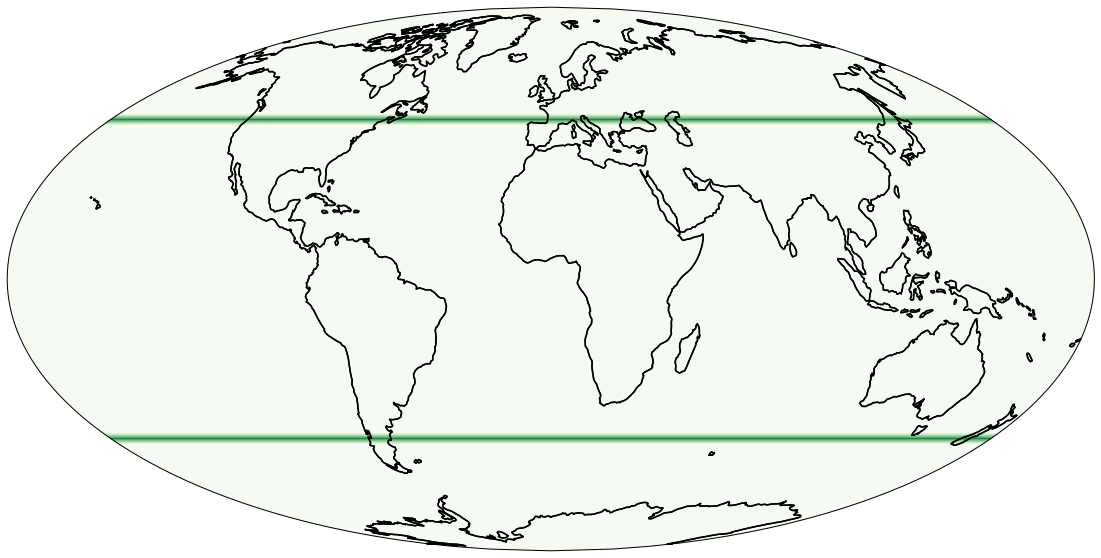

In [20]:
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from numpy import *

plt.figure(figsize=(25,10))
ax = plt.axes(projection=ccrs.Mollweide())
ax.coastlines(lw=1.5)


lats = linspace(-90,90,100)
lons = linspace(-180,180,200)
[L1,L2] = meshgrid(lats,lons)

Z = 1/(abs(L1)-45.0)**2

ax.contourf(lons,lats,Z.T,cmap=cm.Greens,alpha=0.5,transform=ccrs.PlateCarree())

ax.coastlines(lw=1.5)


In [21]:
from numpy import *
from PlotFuncs import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numpy import random
from tqdm import tqdm

In [110]:
# Random DP polarisations sampled isotropically
ngen = 100000
costh = 2*random.uniform(size=ngen)-1
th = arccos(costh)
cos2th = cos(2*th)

# Analytic results (see mathematica notebook for derivation)
costh_av_Z = lambda lat : (1/8)*(3+cos(2*th)-(1+3*cos(2*th))*cos(2*lat*pi/180))
costh_av_N = lambda lat : (1/8)*(3+cos(2*lat*pi/180)+(1+3*cos(2*lat*pi/180))*cos(2*th))
costh_av_W = lambda lat : (sin(th)**2)/2

# Loop over latitudes to show the dependence on lat
nloc = 500
lats = linspace(-75,85,nloc)
val_N = zeros(shape=nloc)
val_Z = zeros(shape=nloc)
val_W = zeros(shape=nloc)

# For each latitude calculate 5th percentile 
# i.e. the value above which 95% of the distribution lies
for i in tqdm(range(0,nloc)):
    val_Z[i] = sort(costh_av_Z(lats[i]))[int(0.05*ngen)]
    val_N[i] = sort(costh_av_N(lats[i]))[int(0.05*ngen)]

100%|██████████| 500/500 [00:07<00:00, 65.09it/s]


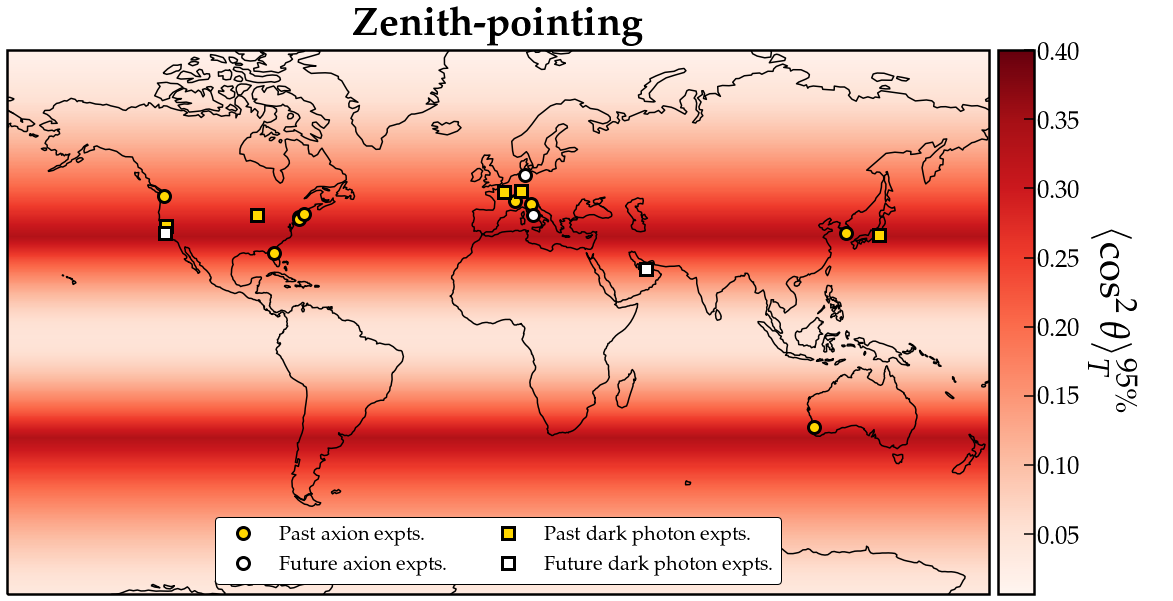

In [179]:
fig,ax = MySquarePlot(size_x=25,size_y=10)
ax = plt.axes(projection=ccrs.Miller(),extent=(-180,180,-75,80))
ax.coastlines(lw=1.5,color='k')
ax.outline_patch.set_linewidth(2.5)

Z = tile(val_Z.T,(2*nloc,1))

lons = linspace(-180,180,2*nloc)


pos1 = array([[47.6062,-122.3321], # ADMX
              [41.3163,-72.9223], # HAYSTAC
             [36.3504, 127.3845], # CAPP
             [45.3457, 11.9639], # QUAX
             [29.6516, -82.3248], # UF
             [46.2044, 6.1432], # RADES
             [40.7793, -72.9154], # RBF
             [-31.9523, 115.8613], # ORGAN
             [42.3736, -71.1097]]) # ABRACADABRA

pos2 = array([[41.8085, 12.6761],
              [53.5724, 9.8805]])

pos3 = array([[41.8364, -88.2636],[48.7367, 2.1800],[35.6762, 139.6503],[49.0069, 8.4037],[38.544,-121.74]])

pos4 = array([[24.4539, 54.3773],[37.4275-1, -122.1697]])

ax.plot(pos1[:,1],pos1[:,0],'o',ms=12,mfc='gold',mec='k',mew=3,label='Past axion expts.',transform=ccrs.PlateCarree())
ax.plot(pos2[:,1],pos2[:,0],'o',ms=12,mfc='w',mec='k',mew=3,label='Future axion expts.',transform=ccrs.PlateCarree())

ax.plot(pos3[:,1],pos3[:,0],'s',ms=12,mfc='gold',mec='k',mew=3,label='Past dark photon expts.',transform=ccrs.PlateCarree())
ax.plot(pos4[:,1],pos4[:,0],'s',ms=12,mfc='w',mec='k',mew=3,label='Future dark photon expts.',transform=ccrs.PlateCarree())

im = ax.pcolormesh(lons,lats,Z.T,cmap=cm.Reds,alpha=1,transform=ccrs.PlateCarree(),vmax=0.4,rasterized = True)
im.set_edgecolor('face')


plt.title(r'{\bf Zenith-pointing}',fontsize=40,pad=15)

cbaxes = fig.add_axes([0.79, 0.125, 0.02, 0.755]) 
cbar = plt.colorbar(im,cax = cbaxes)
cbar.set_label(r'$\langle \cos^2{\theta}\rangle_T^{95\%}$', rotation=-90,labelpad=45,fontsize=40)

cbar.ax.tick_params(which='major',length=10,width=1.5,direction='in')
cbar.solids.set_rasterized(True)
cbar.solids.set_edgecolor("face")

plt.gcf().text(0.87,0.5,'---',color='w',zorder=-100)

ax.legend(loc='lower center',framealpha=1,fontsize=20,ncol=2,edgecolor='k',fancybox=True)

MySaveFig(fig,'Map_Zenith')

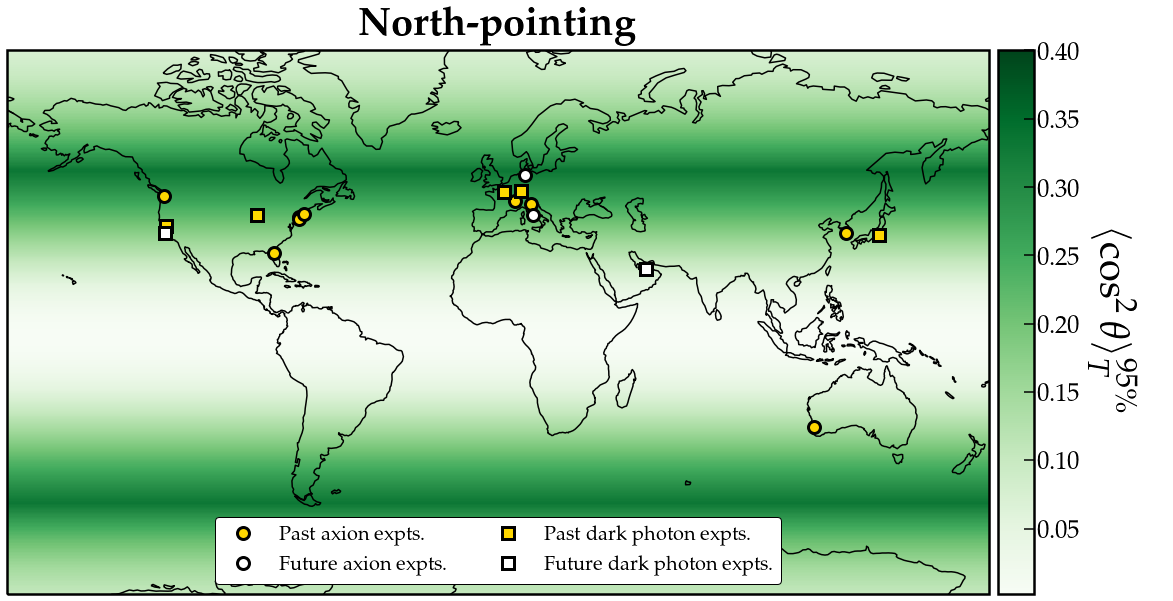

In [178]:
fig,ax = MySquarePlot(size_x=25,size_y=10)
ax = plt.axes(projection=ccrs.Miller(),extent=(-180,180,-75,80))
#ax.coastlines(lw=3,color='w')
ax.coastlines(lw=1.5,color='k')

ax.outline_patch.set_linewidth(2.5)

Z = tile(val_N.T,(2*nloc,1))

ax.plot(pos1[:,1],pos1[:,0],'o',ms=12,mfc='gold',mec='k',mew=3,label='Past axion expts.',transform=ccrs.PlateCarree())
ax.plot(pos2[:,1],pos2[:,0],'o',ms=12,mfc='w',mec='k',mew=3,label='Future axion expts.',transform=ccrs.PlateCarree())

ax.plot(pos3[:,1],pos3[:,0],'s',ms=12,mfc='gold',mec='k',mew=3,label='Past dark photon expts.',transform=ccrs.PlateCarree())
ax.plot(pos4[:,1],pos4[:,0],'s',ms=12,mfc='w',mec='k',mew=3,label='Future dark photon expts.',transform=ccrs.PlateCarree())

#im = ax.contourf(lons,lats,Z.T,levels=30,cmap=cm.Greens,alpha=0.4,transform=ccrs.PlateCarree(),vmax=0.4,antialiased = True)
#im = ax.contourf(lons,lats,Z.T,levels=30,cmap=cm.Greens,alpha=0.4,transform=ccrs.PlateCarree(),vmax=0.4,antialiased = True)
im = ax.pcolormesh(lons,lats,Z.T,cmap=cm.Greens,alpha=1,transform=ccrs.PlateCarree(),vmax=0.4,rasterized = True)
im.set_edgecolor('face')


plt.title(r'{\bf North-pointing}',fontsize=40,pad=15)

cbaxes = fig.add_axes([0.79, 0.125, 0.02, 0.755]) 
cbar = plt.colorbar(im,cax = cbaxes)
cbar.set_label(r'$\langle \cos^2{\theta}\rangle_T^{95\%}$', rotation=-90,labelpad=45,fontsize=40)

cbar.ax.tick_params(which='major',length=10,width=1.5,direction='in')
cbar.solids.set_rasterized(True)
cbar.solids.set_edgecolor("face")

plt.gcf().text(0.87,0.5,'---',color='w',zorder=-100)

ax.legend(loc='lower center',framealpha=1,fontsize=20,ncol=2,edgecolor='k',fancybox=True)

MySaveFig(fig,'Map_North')